### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import os
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask.dataframe as dd
import seaborn as sns
import glob
from tqdm import tqdm
from datetime import datetime


### DASK


In [3]:
cluster = LocalCluster(n_workers=6,  threads_per_worker=2, memory_limit="4GB")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59941,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:59971,Total threads: 2
Dashboard: http://127.0.0.1:59977/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:59944,


2024-08-11 21:01:22,620 - distributed.scheduler - WARNING - Worker failed to heartbeat for 27468s; attempting restart: <WorkerState 'tcp://127.0.0.1:59969', name: 3, status: running, memory: 0, processing: 0>
2024-08-11 21:01:22,630 - distributed.scheduler - WARNING - Worker failed to heartbeat for 27468s; attempting restart: <WorkerState 'tcp://127.0.0.1:59971', name: 0, status: running, memory: 0, processing: 0>
2024-08-11 21:01:22,630 - distributed.scheduler - WARNING - Worker failed to heartbeat for 27468s; attempting restart: <WorkerState 'tcp://127.0.0.1:59972', name: 2, status: running, memory: 0, processing: 0>
2024-08-11 21:01:22,630 - distributed.scheduler - WARNING - Worker failed to heartbeat for 27468s; attempting restart: <WorkerState 'tcp://127.0.0.1:59973', name: 1, status: running, memory: 0, processing: 0>
2024-08-11 21:01:22,630 - distributed.scheduler - WARNING - Worker failed to heartbeat for 27468s; attempting restart: <WorkerState 'tcp://127.0.0.1:59974', name: 5

### Data Directories

In [4]:
# data directories
DATA_DIR = 'data/parking-violations/' # original data
PARQUET_DIR = "data/parquet_files" # partitioned files of augmented data
WEATHER_DIR = 'data/weather/'
AUGMENTED_DIR = 'data/augmented/' # original + augmented data
SCHOOLS_DIR = 'data/schools/'
ATTRACTIONS_DIR = 'data/attractions/'
BUSINESS_DIR = 'data/businesses/'
CRIME_DIR = 'data/crime/'
EVENTS_DIR = 'data/events/'

### Initial exploration of data

In [100]:
# All Parquet files into a Dask DataFrame
df = pd.read_parquet(os.path.join(DATA_DIR, '2014.parquet'))


In [101]:
df.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1361929741,FCJ5493,NY,PAS,12/18/1970,20,SUBN,GMC,S,35030,...,BLACK,0.0,2013.0,-,0.0,None,None,None,None,None
1,1366962000,63540MC,NY,COM,02/02/1971,46,DELV,FRUEH,P,58830,...,BRN,0.0,2013.0,-,0.0,None,None,None,None,None
2,1342296187,GCY4187,NY,SRF,09/18/1971,21,VAN,FORD,S,11790,...,BLUE,0.0,2002.0,-,0.0,None,None,None,None,None
3,1342296199,95V6675,TX,PAS,09/18/1971,21,None,GMC,S,11790,...,SILVR,0.0,2008.0,-,0.0,None,None,None,None,None
4,1342296217,FYM5117,NY,SRF,09/18/1971,21,SUBN,NISSA,S,28190,...,WHITE,0.0,2012.0,-,0.0,None,None,None,None,None


In [120]:
df["Street"]

Dask Series Structure:
npartitions=589
    string
       ...
     ...  
       ...
       ...
Dask Name: getitem, 2 expressions
Expr=ReadParquetFSSpec(ded7669)['Street']

In [13]:
# Head for each column in the dataframe
for col in df.columns:
    print(col)
    print(df[col].head(20))

Summons Number
0     7560453867
1     8030010837
2     8002993251
3     8014184210
4     7463033090
5     7025381809
6     7982768570
7     7069430346
8     8045350957
9     7445114452
10    7445114452
11    7983966945
12    8003077400
13    7005001540
14    7099977398
15    7331565631
16    7933803039
17    7006270121
18    7809040558
19    8006792550
Name: Summons Number, dtype: int64
Plate ID
0       AN921T
1      94866JA
2      77936JY
3     T651285C
4      GRD6305
5      FSW5604
6      75127JX
7      GMZ8407
8      GRP7934
9      GLB5111
10     GLB5111
11     FBA7436
12      XA365T
13     1373675
14     23459MD
15     GPR1134
16     41666JM
17     GBC7778
18     18834MC
19     14580MG
Name: Plate ID, dtype: string
Registration State
0     NJ
1     NY
2     NY
3     NY
4     NY
5     NY
6     NY
7     NY
8     NY
9     NY
10    NY
11    NY
12    NJ
13    IL
14    NY
15    NY
16    NY
17    NY
18    NY
19    NY
Name: Registration State, dtype: string
Plate Type
0     PAS
1     COM
2

In [7]:
df["Violation County"].head()# borough

0    NY
1    NY
2    NY
3     K
4     Q
Name: Violation County, dtype: string

Basic Examination of Data:

Relationship between dataframes:

The 43 columns for the four violation code dataframes are identical, so it will be simple to merge later on.
The violation codes found on the yearly tables can be matched to the 'VIOLATION CODE' column in the descriptors dataframe. This will be helpful when joining the dataframes together.

Any missing data? From first glance, there are missing values in some rows such as: vehicle expiration date and vehicle body type.
Why is this data missing? Some values that are less relevant to New York processing a ticket are missing, while data such as the summons number is never missing.
Any inconsistent data? Some months had significantly less data than other months. Some invalid violation times were found.
Which columns are interesting? The following columns, for the most part, have useful/consistent data that can be used to visualize trends relating to the violations issued.

Issue Date, Plate ID, Violation Code, Registration State, Plate Type, Vehicle Body Type, Vehicle Color, Vehicle Make, Issuing Agency, Violation Time, Vehicle Color, Vehicle Year, Time First Observed, Violation County, Street Name

Which columns are not? The following columns either have too much incosistent data, too many empty cells, or simply a lack relativity to my proposed questions.

From Hours In Effect, To Hours In Effect, Unregistered Vehicle?, Vehicle Year, Meter Number, Feet From Curb, Violation Post Code, Violation Description, No Standing or Stopping Violation, Hydrant Violation, Double Parking Violation, Law Section, Sub Division.

Interesting information I can get out of this data? Trends relating to who was most ticketed, what vehicles were ticketed, where and when violations occur etc.


### Load the aggregated data:

### Schools:

In [41]:
import json

with open(os.path.join(SCHOOLS_DIR, f'borough_school_counts.json'), 'r') as f:
    schools_dict = json.load(f)

# TO ADD BELOW IN THE LOOP: Add the number of schools in the borough where the violation occurred
df['Schools'] = df['Violation County'].map(schools_dict, meta='str')

In [42]:
# change key "M" to "NY"
schools_dict['NY'] = schools_dict.pop('M')
schools_dict['BX'] = schools_dict.pop('X')

In [43]:
schools_dict

{'K': 0.30661205383265067,
 'Q': 0.19953188999414861,
 'R': 0.042715038033937974,
 'O': 0.0011702750146284377,
 'NY': 0.20070216500877705,
 'BX': 0.23990637799882972}

### Events:

In [13]:
events_df = pd.read_csv(os.path.join(EVENTS_DIR, f'events_count.csv'))

In [22]:
events_df.dtypes

date                         datetime64[ns]
borough                              object
events_count                          int64
borough_normalized_events           float64
day_normalized_events               float64
total_events_by_borough               int64
total_events_by_day                   int64
dtype: object

In [21]:
# change the date column to datetime
events_df['date'] = pd.to_datetime(events_df['date'])

In [50]:
events_df
# rename the columns to inclujde the word event in them
events_df.rename(columns={'date': 'event_date', 'borough': 'event_borough'}, inplace=True)

In [51]:
events_df

,event_date,event_borough,events_count,borough_normalized_events,day_normalized_events,total_events_by_borough,total_events_by_day
0,2016-05-21,M,75,0.002606,0.520833,28782,144
1,2015-05-16,M,73,0.002536,0.462025,28782,158
2,2013-09-28,M,70,0.002432,0.679612,28782,103
3,2014-05-17,M,67,0.002328,0.485507,28782,138
4,2016-10-15,M,65,0.002258,0.457746,28782,142
...,...,...,...,...,...,...,...
10460,2014-04-02,B,1,0.000087,0.062500,11519,16
10461,2015-04-02,B,1,0.000087,0.100000,11519,10
10462,2015-04-02,Q,1,0.000094,0.100000,10695,10
10463,2017-11-13,R,1,0.000113,0.200000,8812,5


### Businesses:

In [14]:
with open(os.path.join(BUSINESS_DIR, f'borough_business_counts.json'), 'r') as f:
    business_dict = json.load(f)

# TO ADD BELOW IN THE LOOP: Add the number of schools in the borough where the violation occurred
df['Businesses'] = df['Violation County'].map(business_dict, meta='str')

In [34]:
business_dict

{'K': 0.1789576174519301,
 'Q': 0.16281053114106314,
 'NY': 0.14384907591333734,
 'BX': 0.08778556783091045,
 'O': 0.05250290498306759,
 'R': 0.03292314143269856}

### Attractions:

In [16]:
with open(os.path.join(ATTRACTIONS_DIR, f'borough_attractions_counts.json'), 'r') as f:
    attractions_dict = json.load(f)

# TO ADD BELOW IN THE LOOP: Add the number of schools in the borough where the violation occurred
df['Attractions'] = df['Violation County'].map(attractions_dict, meta='str')

In [33]:
attractions_dict

{'NY': 0.6319218241042345,
 'K': 0.16938110749185667,
 'Q': 0.08143322475570032,
 'BX': 0.06514657980456026,
 'R': 0.05211726384364821}

### Borough cleanup dict

In [44]:
#Dictionary mapping old borough to new borough
boroughs_dict = {'QNS': 'Q','QN' : 'Q', 'KINGS': 'K', 'BK' : 'K', 'BRONX':'BX', 'MN' : 'NY','ST' : 'R' }

## Merging dataframes of different years and weather data + aggregated data:

In [52]:

# Initialize an empty list to collect DataFrames
df_list = []

# Fiscal year range (FY 2014 and 2015)
fiscal_years = list(range(2014, 2025))

for i in fiscal_years:
    # Load the parquet file for parking violations
    violations_df = pd.read_parquet(os.path.join(DATA_DIR, f'{i}.parquet'))
    # Convert Issue Date to datetime
    print(f"Year: {i}")
    print(f"Number of rows: {len(violations_df)}")
    print("---------------------------------------------------")
    violations_df['Issue Date'] = pd.to_datetime(violations_df['Issue Date'])

    # BOROUGHS:----------------------------
    #replace function using the dict will convert the old boroughs to the new boroughs
    violations_df['Violation County'] = violations_df['Violation County'].replace(boroughs_dict)
    # show only the 5 known boroughs and other
    violations_df = violations_df[violations_df['Violation County'].isin(['K', 'Q', 'BX', 'NY', 'R', 'O'])]
    #--------------------------------------

    # Filter for fiscal year (July 1 previous year to June 30 current year)
    start_date = datetime(i-1, 7, 1)
    end_date = datetime(i, 6, 30)
    violations_df = violations_df[(violations_df['Issue Date'] >= start_date) & (violations_df['Issue Date'] <= end_date)]

    # keep only interesting columns:
    # Issue Date, Plate ID, Violation Code, Registration State, Plate Type, Vehicle Body Type, Vehicle Color, Vehicle Make, Issuing Agency, Violation Time, Vehicle Color, Vehicle Year, Time First Observed, Violation County, Street Name
    #violations_df = violations_df[['Issue Date', 'Plate ID', 'Violation Code', 'Registration State', 'Plate Type', 'Vehicle Body Type', 'Vehicle Color', 'Vehicle Make', 'Issuing Agency', 'Violation Time', 'Vehicle Year', 'Time First Observed', 'Violation County', 'Street']]
    
    # Load the corresponding weather data
    weather_df = pd.read_csv(os.path.join(WEATHER_DIR, f'weather_{i}.csv'))
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
    
    # Merge the parking violations data with the weather data
    merged_df = pd.merge(violations_df, weather_df, left_on='Issue Date', right_on='DATE', how='left')
    
    # Drop the DATE column from weather data as it's redundant
    merged_df = merged_df.drop(columns=['DATE'])

    # OTHER AUGMENTATIONS:
    # 2. SCHOOLS:
    merged_df['Schools'] = merged_df['Violation County'].map(schools_dict)
    # 3. BUSINESS:
    merged_df['Businesses'] = merged_df['Violation County'].map(business_dict)
    # 4. ATTRACTIONS:
    merged_df['Attractions'] = merged_df['Violation County'].map(attractions_dict)
    # 5. EVENTS: # merge on both date and borough, but keep only the count column
    merged_df = pd.merge(merged_df, events_df, left_on=['Issue Date', 'Violation County'], right_on=['event_date', 'event_borough'], how='left')
    

    # save the merged df to a parquet file
    merged_df.to_parquet(os.path.join(AUGMENTED_DIR, f'{i}_augmented.parquet'))

    # Append the merged DataFrame to the list
    #df_list.append(merged_df)
    del violations_df, weather_df, merged_df

# Concatenate all DataFrames in the list
#df_all = pd.concat(df_list, ignore_index=True)

#print(f"Total number of rows: {len(df_all)}")
#print(df_all.head())


Year: 2014
Number of rows: 9100278
---------------------------------------------------
Year: 2015
Number of rows: 11809233
---------------------------------------------------
Year: 2016
Number of rows: 10626899
---------------------------------------------------
Year: 2017
Number of rows: 10803028
---------------------------------------------------
Year: 2018
Number of rows: 11721626
---------------------------------------------------
Year: 2019
Number of rows: 11467506
---------------------------------------------------
Year: 2020
Number of rows: 12495734
---------------------------------------------------


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_23764\2753906607.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  violations_df['Issue Date'] = pd.to_datetime(violations_df['Issue Date'])


Year: 2021
Number of rows: 14955523
---------------------------------------------------
Year: 2022
Number of rows: 15435607
---------------------------------------------------
Year: 2023
Number of rows: 21563258
---------------------------------------------------
Year: 2024
Number of rows: 12008298
---------------------------------------------------


In [56]:
df_2014 = pd.read_parquet(os.path.join(AUGMENTED_DIR, '2014_augmented.parquet'))
for column in df_2014.columns:
    print(df_2014[column].head(8))

0    1351801788
1    1351801790
2    1351801806
3    1335816975
4    1346074630
5    1323267980
6    1254057390
7    1325195236
Name: Summons Number, dtype: int64
0    41666JM
1    99208MC
2    49965JG
3    89985MC
4     XZ366C
5    67015JY
6    GDG1828
7    93948JZ
Name: Plate ID, dtype: object
0    NY
1    NY
2    NY
3    NY
4    NJ
5    NY
6    NY
7    NY
Name: Registration State, dtype: object
0    COM
1    COM
2    COM
3    COM
4    PAS
5    COM
6    PAS
7    COM
Name: Plate Type, dtype: object
0   2013-07-02
1   2013-07-02
2   2013-07-02
3   2013-07-01
4   2013-07-01
5   2013-07-01
6   2013-07-01
7   2013-07-01
Name: Issue Date, dtype: datetime64[ns]
0    14
1    14
2    14
3    78
4    46
5    14
6    46
7    20
Name: Violation Code, dtype: int64
0     VAN
1     VAN
2     VAN
3     VAN
4     VAN
5    REFG
6     SDN
7     VAN
Name: Vehicle Body Type, dtype: object
0     None
1     None
2     None
3    MITSU
4    ISUZU
5    INTER
6     FORD
7    CHEVR
Name: Vehicle Make, dtype: ob

## EDA (parquet + Dask)

### Plotting only one column (choose which one in columns_to_keep)

In [5]:
# Columns to keep
columns_to_keep = [
    'Issue Date', 
    #'Plate ID', 
    #'Violation Code', 
    #'Registration State', #- for plotting
    #'Plate Type', 
    #'Vehicle Body Type', 
    #'Vehicle Color', 
    #'Vehicle Make', 
    #'Issuing Agency', 
    #'Violation Time', 
    #'Vehicle Year', 
    #'Time First Observed', 
    'Violation County', 
    'Street'
]

In [6]:
os.path.join(PARQUET_DIR, '*.parquet')

'data/parquet_files\\*.parquet'

In [7]:
df = dd.read_parquet(os.path.join(PARQUET_DIR, '*.parquet'))#, columns=columns_to_keep)

In [8]:
# n largest for street
df.dtypes

Summons Number                       string[pyarrow]
Plate ID                             string[pyarrow]
Registration State                   string[pyarrow]
Plate Type                           string[pyarrow]
Issue Date                           string[pyarrow]
Violation Code                       string[pyarrow]
Vehicle Body Type                    string[pyarrow]
Vehicle Make                         string[pyarrow]
Issuing Agency                       string[pyarrow]
Street Code1                         string[pyarrow]
Street Code2                         string[pyarrow]
Street Code3                         string[pyarrow]
Vehicle Expiration Date              string[pyarrow]
Violation Location                   string[pyarrow]
Violation Precinct                   string[pyarrow]
Issuer Precinct                      string[pyarrow]
Issuer Code                          string[pyarrow]
Issuer Command                       string[pyarrow]
Issuer Squad                         string[py

In [107]:
print(df.isnull().sum().compute()) # time: 3min 45s

Summons Number                               0
Plate ID                                  9847
Registration State                           0
Plate Type                                   0
Issue Date                                   0
Violation Code                               0
Vehicle Body Type                       376456
Vehicle Make                            487344
Issuing Agency                               2
Street Code1                                 0
Street Code2                                 0
Street Code3                                 0
Vehicle Expiration Date                9420913
Violation Location                    33833432
Violation Precinct                           0
Issuer Precinct                              0
Issuer Code                                  0
Issuer Command                        60409152
Issuer Squad                          96524148
Violation Time                             907
Time First Observed                  121993169
Violation Cou

Top 10 streets

In [8]:
parquet_files = glob.glob(os.path.join(PARQUET_DIR, '*.parquet'))
df = pd.concat([pd.read_parquet(file, columns=["Street"]) for file in tqdm(parquet_files)])


100%|██████████| 589/589 [00:46<00:00, 12.74it/s]


In [14]:
len(df), df.head()

(129667354,
                             Street
 __null_dask_index__               
 0                       WILLIAM ST
 1                       WILLIAM ST
 2                         BROAD ST
 3                    BARROW STREET
 4                          E 23 ST)

In [9]:
df['Street'].value_counts().nlargest(10)

Street
Broadway         2208630
3rd Ave          1615833
5th Ave          1034700
Madison Ave       954730
2nd Ave           855677
Lexington Ave     832241
1st Ave           732592
Queens Blvd       649620
7th Ave           633249
8th Ave           619268
Name: count, dtype: Int64

In [10]:
street_counts = df['Street'].value_counts()

In [27]:
top_streets = street_counts.nlargest(25)
top_streets

Street
Broadway                2208630
3rd Ave                 1615833
5th Ave                 1034700
Madison Ave              954730
2nd Ave                  855677
Lexington Ave            832241
1st Ave                  732592
Queens Blvd              649620
7th Ave                  633249
8th Ave                  619268
6th Ave                  616586
Amsterdam Ave            565884
Jamaica Ave              507260
37th Ave                 452280
Park Ave                 450224
Roosevelt Ave            431763
Columbus Ave             423975
Coney Island Ave         356428
White Plains Rd          341983
9th Ave                  329330
Fulton St                320554
Main St                  316441
EB HORACE HARDING EX     316013
Nostrand Ave             306311
Myrtle Ave               302834
Name: count, dtype: Int64

In [21]:
type(top_streets)

pandas.core.series.Series

In [12]:
# extract top 10 street names
top_streets_names = top_streets.index.tolist()
top_streets_names

NameError: name 'top_streets' is not defined

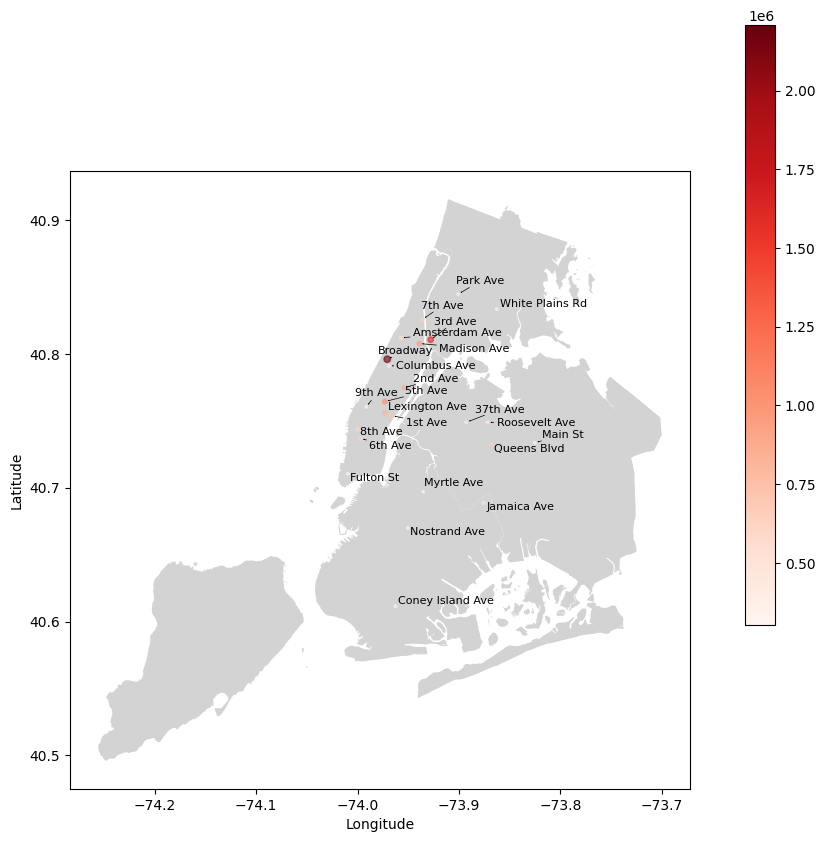

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geodatasets import get_path
from adjustText import adjust_text  # Import adjustText for label adjustment

# Assuming top_streets is a Series where the index is the street name and the value is the violation count

# Convert the Series to a DataFrame
df = top_streets.reset_index()
df.columns = ['Street', 'Violations']

# Geocoding: Get the latitude and longitude for each street
geolocator = Nominatim(user_agent="parking_violations")
df['Coordinates'] = df['Street'].apply(lambda x: geolocator.geocode(f"{x}, New York, NY"))

# Filter out None values (in case some addresses couldn't be geocoded)
df = df.dropna(subset=['Coordinates'])

# Extract latitude and longitude
df['Latitude'] = df['Coordinates'].apply(lambda x: x.latitude)
df['Longitude'] = df['Coordinates'].apply(lambda x: x.longitude)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Set the coordinate reference system to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)



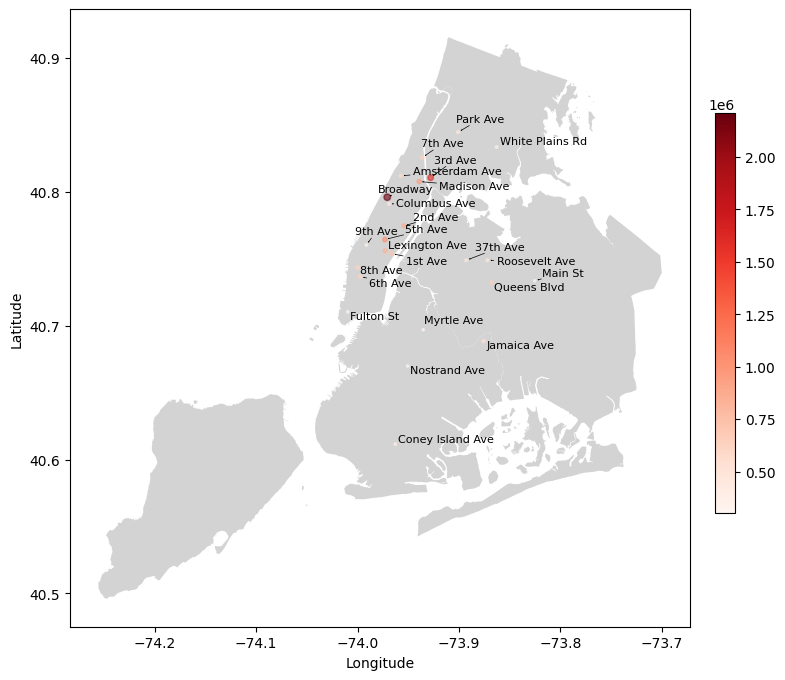

In [36]:
# Plotting the streets on a map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# NYC map using GeoPandas with the new geodatasets package
nyc_map_path = get_path('nybb')
nyc_map = gpd.read_file(nyc_map_path)
nyc_map = nyc_map.to_crs(epsg=4326)

nyc_map.plot(ax=ax, color='lightgrey')

# Plot the points, color-coded by the number of violations
sc = gdf.plot(
    ax=ax,
    markersize=gdf['Violations'].apply(lambda x: x / 100000),  # Adjust marker size based on violations
    alpha=0.6,
    column='Violations',  # Use 'column' to specify which data column to color by
    cmap='Reds',
    legend=True
)

# Adjust the colorbar size
cbar = plt.gcf().get_axes()[1]
cbar.set_position([0.77, 0.3, 0.03, 0.4])

# Annotate the streets with adjusted text placement to prevent overlap
texts = []
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Street']):
    texts.append(ax.text(x, y, label, fontsize=8))

# Use adjust_text to prevent overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

#plt.title("Top Streets with Most Parking Violations in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("plots/map_top_streets_violations.png")
plt.show()


In [19]:
top_streets[['Coordinates']]

Street
Coordinates    Index([('Broadway, Bloomingdale, Manhattan Com...
Name: count, dtype: object

In [110]:
client.get_versions(check=True)

{'scheduler': {'host': {'python': '3.12.3.final.0',
   'python-bits': 64,
   'OS': 'Windows',
   'OS-release': '11',
   'machine': 'AMD64',
   'processor': 'Intel64 Family 6 Model 154 Stepping 3, GenuineIntel',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'None'},
  'packages': {'python': '3.12.3.final.0',
   'dask': '2024.5.0',
   'distributed': '2024.5.0',
   'msgpack': '1.0.3',
   'cloudpickle': '2.2.1',
   'tornado': '6.4.1',
   'toolz': '0.12.0',
   'numpy': '1.26.4',
   'pandas': '2.2.2',
   'lz4': '4.3.2'}},
 'workers': {'tcp://127.0.0.1:55072': {'host': {'python': '3.12.3.final.0',
    'python-bits': 64,
    'OS': 'Windows',
    'OS-release': '11',
    'machine': 'AMD64',
    'processor': 'Intel64 Family 6 Model 154 Stepping 3, GenuineIntel',
    'byteorder': 'little',
    'LC_ALL': 'None',
    'LANG': 'None'},
   'packages': {'python': '3.12.3.final.0',
    'dask': '2024.5.0',
    'distributed': '2024.5.0',
    'msgpack': '1.0.3',
    'cloudpickle': '2.2.1',
    '

In [80]:
df.head(20)

,Issue Date,Violation County
0,2013-07-02,NY
1,2013-07-02,NY
2,2013-07-02,NY
3,2013-07-01,NY
4,2013-07-01,NY
5,2013-07-01,NY
6,2013-07-01,BX
7,2013-07-01,Q
8,2013-07-01,K
9,2013-07-01,NY


In [64]:
len(df)

129667354

In [ ]:
# count nan values for county - before removing them
count_nan = df['Violation County'].isna().sum().compute()
print(df['Violation County'].isna().sum().compute())
# percentage of nan values
print(df['Violation County'].isna().sum()/len(df)*100)

4321518
3.495326941644613


In [72]:
df_all = df

In [73]:
#First create a dictionary mapping old borough to new borough
boroughs_dict = {'QNS': 'Q','QN' : 'Q', 'KINGS': 'K', 'BK' : 'K', 'BRONX':'BX', 'MN' : 'NY','ST' : 'R' }
#replace function using the dict will convert the old boroughs to the new boroughs
df_all['Violation County'] = df_all['Violation County'].replace(boroughs_dict)
#Filtering out all violation boroughs that are NOT P, as P is very unclear to what it represents. not including




In [78]:
df_all.head(20)

,Issue Date,Violation County
0,2013-07-02,NY
1,2013-07-02,NY
2,2013-07-02,NY
3,2013-07-01,NY
4,2013-07-01,NY
5,2013-07-01,NY
6,2013-07-01,BX
7,2013-07-01,Q
8,2013-07-01,K
9,2013-07-01,NY


In [84]:
borough_violations = df_all['Violation County'].value_counts().compute()
borough_violations.columns = ['Borough', 'Number of Violations']


RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9276\1219301620.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_violations, x='Borough', y='Number of Violations', palette='viridis')


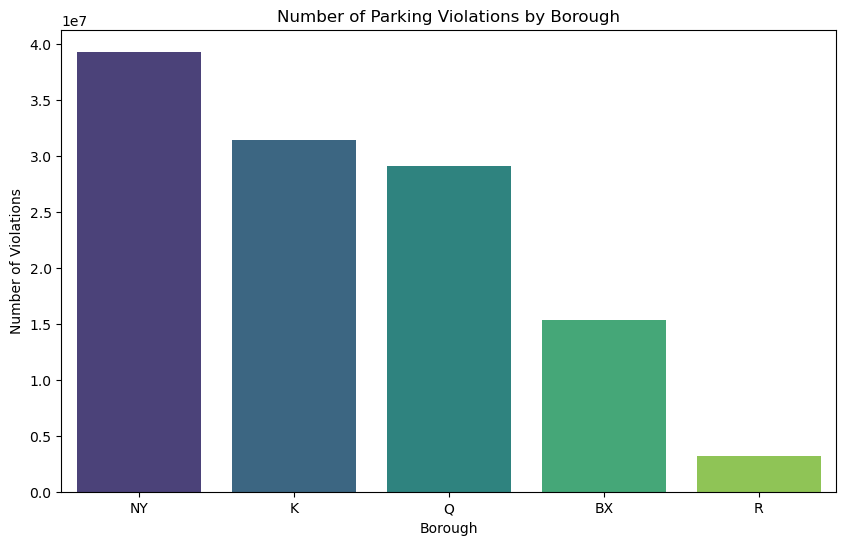

In [34]:

# show only the 5 known boroughs
borough_violations = borough_violations[borough_violations['Borough'].isin(['K', 'Q', 'BX', 'NY', 'R'])]

# Step 4: Plot the Data
plt.figure(figsize=(10, 6))
sns.barplot(data=borough_violations, x='Borough', y='Number of Violations', palette='viridis')
plt.title('Number of Parking Violations by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Violations')
plt.show()

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_12808\1206873442.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=street_value_counts.index[:10], y=street_value_counts[:10], palette='viridis')


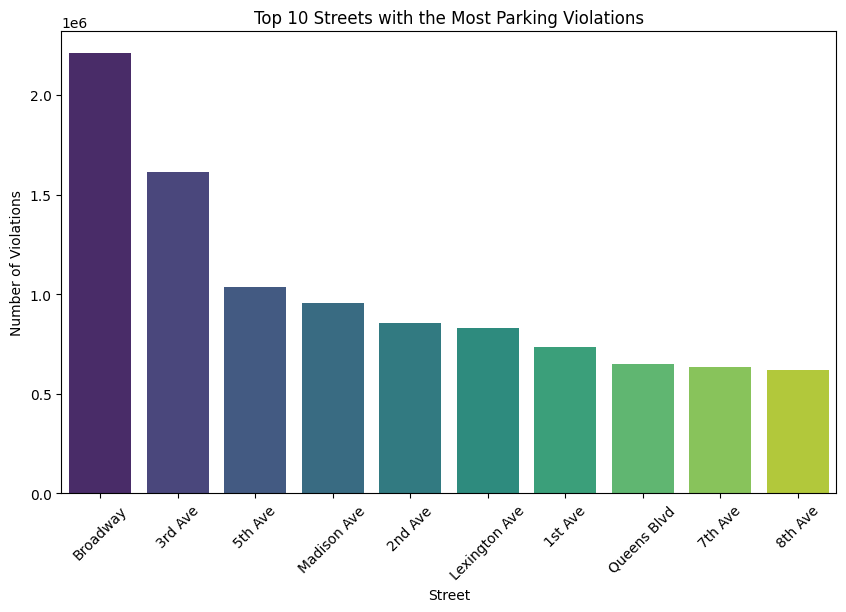

In [132]:
plt.figure(figsize=(10, 6))
street_value_counts = df['Street'].value_counts()
sns.barplot(x=street_value_counts.index[:10], y=street_value_counts[:10], palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Streets with the Most Parking Violations')
plt.xlabel('Street')
plt.ylabel('Number of Violations')
plt.savefig('plots/top_10_streets.png')
plt.show()

In [13]:
# for each element which is year in df list get the length of the dataframe and save it and plot it
df_length = [len(df) for df in df_list]

In [15]:
fiscal_years = range(2014, 2024)

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9276\2938527081.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lengths_df, x='Fiscal Year', y='Number of Violations', palette='viridis')


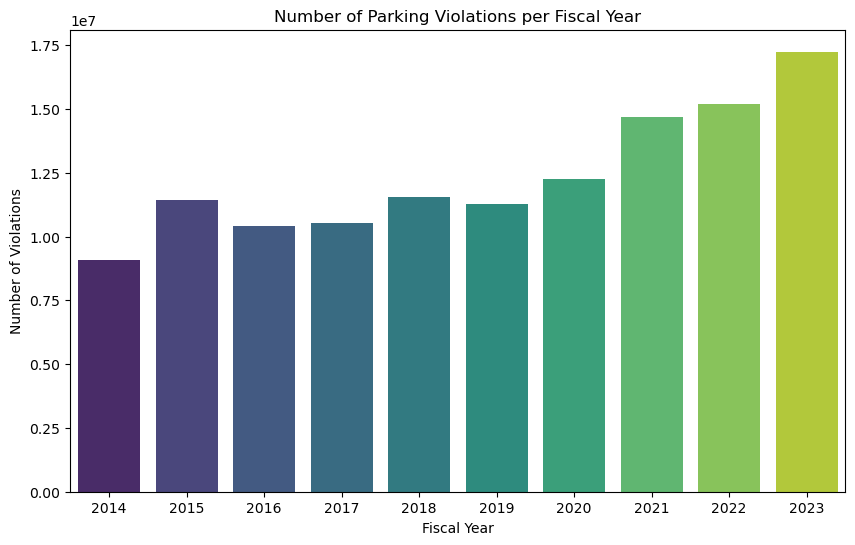

In [16]:
# Create a DataFrame for plotting
lengths_df = pd.DataFrame({
    'Fiscal Year': fiscal_years,
    'Number of Violations': df_length
})

# Plot the number of violations per fiscal year
plt.figure(figsize=(10, 6))
sns.barplot(data=lengths_df, x='Fiscal Year', y='Number of Violations', palette='viridis')
plt.title('Number of Parking Violations per Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Violations')
plt.show()

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9276\2957368421.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all, x='Registration State', palette='viridis', order=df_all['Registration State'].value_counts().index)


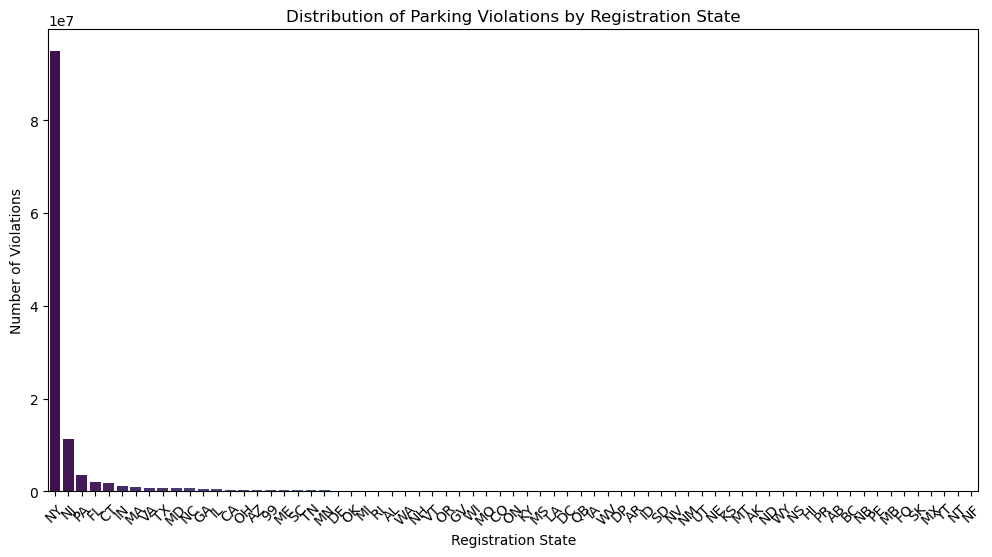

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_all is your DataFrame with the combined data
# Plot the distribution of registration states
plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x='Registration State', palette='viridis', order=df_all['Registration State'].value_counts().index)
plt.title('Distribution of Parking Violations by Registration State')
plt.xlabel('Registration State')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)
plt.show()


In [8]:
len(df_all)

123637018

### Dask


In [10]:
import dask.dataframe as dd

# Load the DataFrame with Dask
df_dask = dd.from_pandas(df_all, npartitions=10)

# Compute the top 10 registration states
top_10_states = df_dask['Registration State'].value_counts().nlargest(10).compute()

# Extract the top 10 states
top_10_states_list = top_10_states.index.tolist()


In [ ]:
# Filter the Dask DataFrame for the top 10 states
df_top_10_dask = df_dask[df_dask['Registration State'].isin(top_10_states_list)]

# Convert to Pandas DataFrame for plotting
df_top_10 = df_top_10_dask.compute()


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9276\786965121.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top_10, x='Registration State', palette='viridis', order=top_10_states_list)


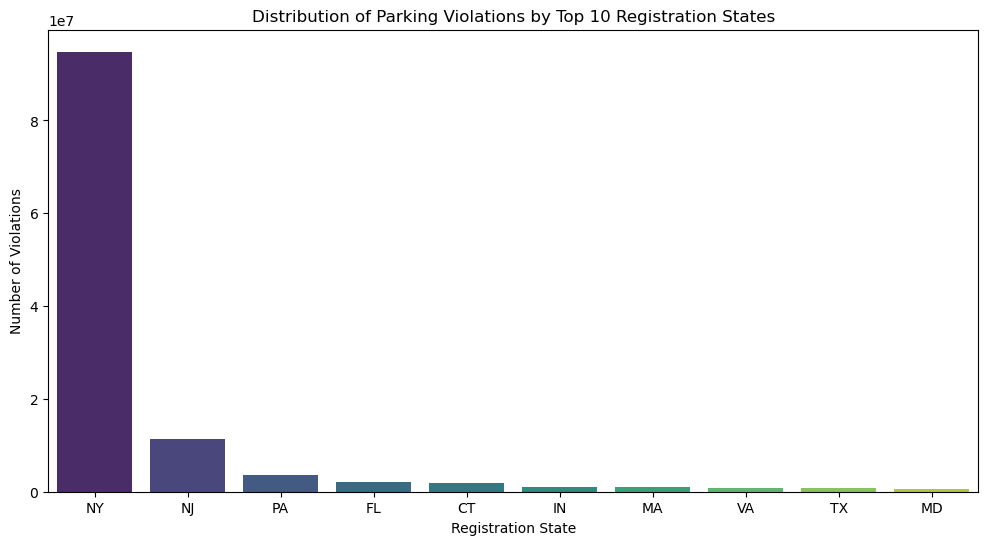

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the top 10 registration states
plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_10, x='Registration State', palette='viridis', order=top_10_states_list)
plt.title('Distribution of Parking Violations by Top 10 Registration States')
plt.xlabel('Registration State')
plt.ylabel('Number of Violations')
#plt.xticks(rotation=45)
plt.show()


### Tickets per day


In [17]:
#Aggregate the data to get the number of tickets per day
tickets_per_day = df_all.groupby('Issue Date').size().reset_index(name='Number of Tickets')


In [23]:
tickets_per_day

,Issue Date,Number of Tickets
0,2013-07-01,147
1,2013-07-02,325
2,2013-07-03,337
3,2013-07-04,135
4,2013-07-05,282
...,...,...
3645,2023-06-26,46577
3646,2023-06-27,48932
3647,2023-06-28,37965
3648,2023-06-29,35109


In [24]:
sorted_tickets_per_day = tickets_per_day.sort_values(by='Number of Tickets', ascending=False)

sorted_tickets_per_day

,Issue Date,Number of Tickets
563,2015-01-15,83112
561,2015-01-13,81154
564,2015-01-16,80007
568,2015-01-20,78998
570,2015-01-22,78232
...,...,...
2919,2021-06-30,3
2189,2019-06-29,3
2553,2020-06-27,2
3284,2022-06-30,2


In [19]:

# Assuming the DataFrame already contains the average precipitation per day
avg_precipitation_per_day = df_all[['Issue Date', 'PRCP']].drop_duplicates()


In [21]:
avg_precipitation_per_day

,Issue Date,PRCP
0,2013-07-29,0.01
1,2013-07-11,0.00
3,2013-07-02,0.08
8,2013-07-01,0.84
54,2013-07-12,0.25
...,...,...
121300123,2023-06-30,0.00
122014958,2023-06-02,0.24
122014990,2023-06-04,0.00
122014998,2023-06-08,0.00


Correlation between average precipitation and number of tickets: -0.08291269445098488


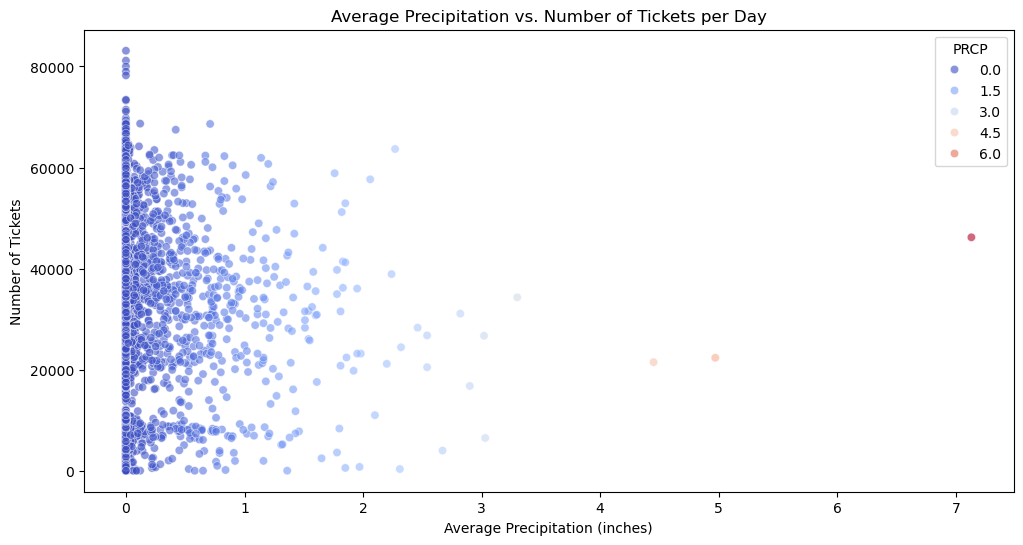

In [22]:

# Merge the two DataFrames on 'Issue Date'
merged_data = pd.merge(tickets_per_day, avg_precipitation_per_day, on='Issue Date')

# Compute the correlation between average precipitation and number of tickets
correlation = merged_data['Number of Tickets'].corr(merged_data['PRCP'])
print(f'Correlation between average precipitation and number of tickets: {correlation}')

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_data, x='PRCP', y='Number of Tickets', hue='PRCP', palette='coolwarm', alpha=0.6)
plt.title('Average Precipitation vs. Number of Tickets per Day')
plt.xlabel('Average Precipitation (inches)')
plt.ylabel('Number of Tickets')
plt.show()

In [9]:
df = df_all

In [ ]:
df["Street Name"].value_counts().head(100).plot(kind='barh', figsize=(10, 6))

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Double Parking Violation,STATION,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,House Number,Street Name
0,6020407718,905UD,NY,PAS,2013-07-29,94,None,TRIUM,X,0,...,None,USW00094728,3.80,0.01,0.0,NaN,85,69,NaN,NaN
1,6020367964,GFN8155,NY,PAS,2013-07-11,94,SDN,AUDI,X,0,...,None,USW00094728,3.80,0.00,0.0,NaN,84,76,NaN,NaN
2,6020405473,GDN8721,NY,PAS,2013-07-11,94,SUBN,HONDA,X,0,...,None,USW00094728,3.80,0.00,0.0,NaN,84,76,NaN,NaN
3,1351801788,41666JM,NY,COM,2013-07-02,14,VAN,None,P,45440,...,None,USW00094728,2.68,0.08,0.0,NaN,82,72,NaN,NaN
4,6020407172,GHK8831,NY,PAS,2013-07-11,94,SDN,DODGE,X,0,...,None,USW00094728,3.80,0.00,0.0,NaN,84,76,NaN,NaN


In [10]:
del df_list

In [10]:
# Converting to datetime format
cols_dates = ['Issue Date', 'Vehicle Expiration Date', 'Date First Observed']

for col in cols_dates:
    df[col] = df[col].astype(str)
    df[col] = dd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')


In [11]:
# get min and max dates
min_date = df['Issue Date'].min()
max_date = df['Issue Date'].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 1970-12-18 00:00:00
Max date: 2069-12-23 00:00:00


In [13]:
df = df[['Issue Date', 'Plate ID', 'Violation Code', 'Registration State', 'Plate Type', 'Vehicle Body Type', 'Vehicle Color', 'Vehicle Make', 'Issuing Agency', 'Violation Time', 'Vehicle Year', 'Time First Observed', 'Violation County', 'Street']]

In [15]:
# Display basic information and summary statistics
print(df.info())
print(df.describe())

# Summary statistics for numeric columns
numeric_summary = df.describe()

# Summary statistics for categorical columns
categorical_summary = df.describe(include=['object'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20524031 entries, 0 to 20524030
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Issue Date           datetime64[ns]
 1   Plate ID             object        
 2   Violation Code       int64         
 3   Registration State   object        
 4   Plate Type           object        
 5   Vehicle Body Type    object        
 6   Vehicle Color        object        
 7   Vehicle Make         object        
 8   Issuing Agency       object        
 9   Violation Time       object        
 10  Vehicle Year         float64       
 11  Time First Observed  object        
 12  Violation County     object        
 13  Street               object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 2.1+ GB
None
                          Issue Date  Violation Code  Vehicle Year
count                       20524031    2.052403e+07  2.052403e+07
mean   2

In [88]:
# get me top 10 most common streets
top_10_streets = df['Street'].value_counts().nlargest(10).compute()
print(top_10_streets)

KeyError: 'Street'

In [12]:
df.dtypes

Summons Number                                int64
Plate ID                                     object
Registration State                           object
Plate Type                                   object
Issue Date                           datetime64[ns]
Violation Code                                int64
Vehicle Body Type                            object
Vehicle Make                                 object
Issuing Agency                               object
Street Code1                                  int64
Street Code2                                  int64
Street Code3                                  int64
Vehicle Expiration Date              datetime64[ns]
Violation Location                          float64
Violation Precinct                            int64
Issuer Precinct                               int64
Issuer Code                                   int64
Issuer Command                               object
Issuer Squad                                 object
Violation Ti

In [13]:
# augment the data with additional columns
df.head()


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,House Number,Street Name
0,1361929741,FCJ5493,NY,PAS,1970-12-18,20,SUBN,GMC,S,35030,...,2013.0,-,0.0,None,None,None,None,None,NaN,NaN
1,1366962000,63540MC,NY,COM,1971-02-02,46,DELV,FRUEH,P,58830,...,2013.0,-,0.0,None,None,None,None,None,NaN,NaN
2,1342296187,GCY4187,NY,SRF,1971-09-18,21,VAN,FORD,S,11790,...,2002.0,-,0.0,None,None,None,None,None,NaN,NaN
3,1342296199,95V6675,TX,PAS,1971-09-18,21,None,GMC,S,11790,...,2008.0,-,0.0,None,None,None,None,None,NaN,NaN
4,1342296217,FYM5117,NY,SRF,1971-09-18,21,SUBN,NISSA,S,28190,...,2012.0,-,0.0,None,None,None,None,None,NaN,NaN


In [7]:

# Display basic information about the DataFrame
print(df.head())
print(df.info())

print(df.columns)

   Summons Number Plate ID Registration State Plate Type Issue Date  \
0      1361929741  FCJ5493                 NY        PAS 1970-12-18   
1      1366962000  63540MC                 NY        COM 1971-02-02   
2      1342296187  GCY4187                 NY        SRF 1971-09-18   
3      1342296199  95V6675                 TX        PAS 1971-09-18   
4      1342296217  FYM5117                 NY        SRF 1971-09-18   

   Violation Code Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  \
0              20              SUBN          GMC              S         35030   
1              46              DELV        FRUEH              P         58830   
2              21               VAN         FORD              S         11790   
3              21              None          GMC              S         11790   
4              21              SUBN        NISSA              S         28190   

   ...  Vehicle Color  Unregistered Vehicle? Vehicle Year  Meter Number  \
0  ...     

In [8]:
# Distribution of violations by year
violations_by_year = df['Issue Date'].dt.year.value_counts()#.compute()
print(violations_by_year)

Issue Date
2014    4716512
2013    4379109
2015       1522
2012        618
2019        329
         ...   
1991          1
1983          1
1977          1
1974          1
2069          1
Name: count, Length: 68, dtype: int64


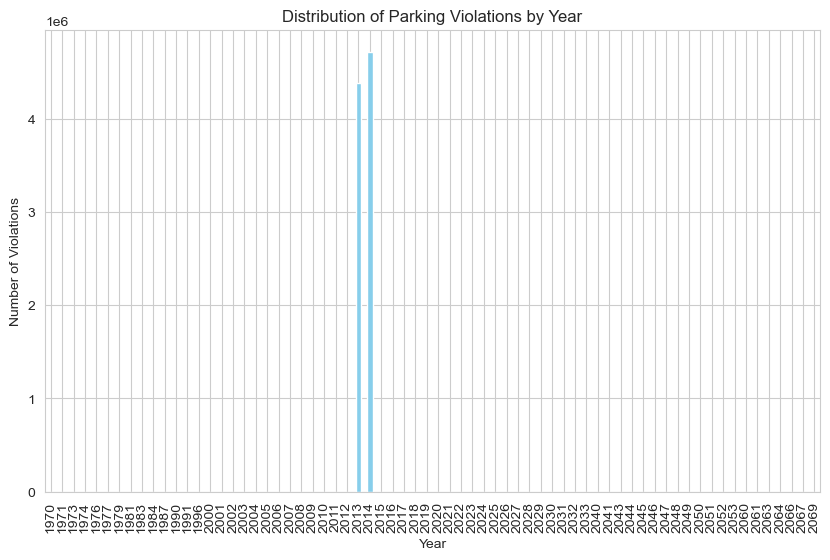

In [17]:
import matplotlib.pyplot as plt

# Create a bar plot
violations_by_year.sort_index().plot(kind='bar', color='skyblue', figsize=(10, 6))

# Add titles and labels
plt.title('Distribution of Parking Violations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Violations')

# Show the plot
plt.show()


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_26440\2073399808.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=violations_by_year.index, y=violations_by_year.values, palette='viridis')


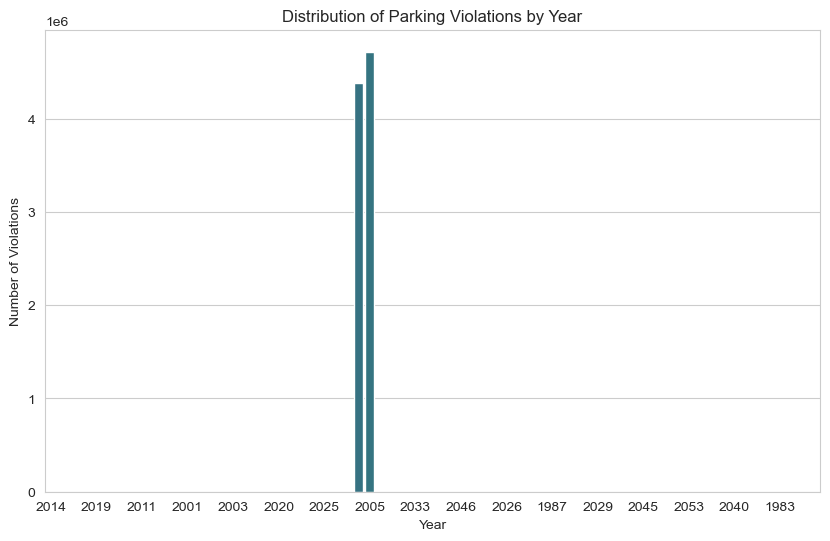

In [16]:
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=violations_by_year.index, y=violations_by_year.values, palette='viridis')

# Add titles and labels
plt.title('Distribution of Parking Violations by Year')
plt.xlabel('Year')
# x ticks only every 2 years
plt.xticks(range(0, len(violations_by_year), 4), violations_by_year.index[::4])
plt.ylabel('Number of Violations')

# Show the plot
plt.show()


In [ ]:
# Distribution of violations by borough
violations_by_borough = df['borough'].value_counts().compute()
print(violations_by_borough)

# Total number of violations
total_violations = df.shape[0].compute()
print("Total number of violations:", total_violations)

# Number of violations per year
violations_per_year = df.groupby(df['issue_date'].dt.year).size().compute()
print(violations_per_year)

# Number of violations per borough
violations_per_borough = df.groupby('borough').size().compute()
print(violations_per_borough)

# Most common violation types
common_violations = df['violation_code'].value_counts().compute()
print(common_violations)

# Example: Correlation between violations and temperature
# Assume 'temperature' column is added during augmentation
correlation = df[['violation_count', 'temperature']].corr().compute()
print(correlation)

# Plotting the relationship between violations and temperature
plt.figure(figsize=(10, 6))
plt.scatter(df['temperature'].compute(), df['violation_count'].compute(), alpha=0.5)
plt.title('Violations vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Violations')
plt.show()